#Parallel computing using REBOUND and IPython/Jupyter
In this tutorial, we'll use IPython for parallel and distributed REBOUND simulations. With IPython, we can execute code on multi-core machines, both locally and remotely. This is particularly interesting for running many small simulations that do not have to communicate a lot with each other. Thus, a paramerter space survey with REBOUND is ideally suited.

Note thate this tutorial does not cover how to setup the IPython cluster profile, please refer to the IPython documentation for that. 

First, we'll initialize the IPython cluster. In our case, we have setup IPython to run on two machine which have in together 22 CPUs and can run a total 44 threads in parallel. The machines are connected via ethernet and the login is handled ssh. We'll also create a load_balanced_view, a scheduler that distributes the jobs to engines that are free and import rebound on all engines.

In [1]:
from IPython.parallel import Client
rc = Client()
print "Cluster size: %d" % len(rc.ids)
lv = rc.load_balanced_view()
lv.block = True

Cluster size: 44


Next, we import rebound on all of our engines. `rc[:]` is a "direct view" of all engines.

In [2]:
with rc[:].sync_imports():
    import rebound

importing rebound on engine(s)


Next, we define a python function that runs one simulation. We add a star and two planets. The eccentricity and semi-major axis of the outer planet are passed to the function as a parameter.

We choose the `whfast-nocor` integrator, i.e. WHFast with no symplectic correctors, because we are not interested in the most accurate integration but rather want to have it run fast to get a quick overview of the parameter space. While we integrate, we check for escaping particles. If a particle escapes we know that the simulation is unstable and can terminate the integration.

In [3]:
def simulation(par):
    a, e = par # unpack parameters
    rebound.reset() 
    rebound.integrator = "whfast-nocor"
    rebound.dt = 5.
    rebound.add(m=1.)
    rebound.add(m=0.000954, a=5.204, anom=0.600, omega=0.257, e=0.048)
    rebound.add(m=0.000285, a=a, anom=0.871, omega=1.616, e=e)
    rebound.move_to_com()
    rebound.init_megno(1e-16)
    try:
        rebound.integrate(5e2*2.*3.1415,maxR=20.) # integrator for 500 years
        return rebound.calculate_megno()
    except rebound.ParticleEscaping:
        return 10. # At least one particle got ejected, returning large MEGNO.

Next, we're creating a 2D array of parameters to sample. Here, it's in the $a$/$e$ plane of parameter space and we create a 200x200 matrix. Then, we finally execute the simulations on the cluster using the `map` function on our load balanced view object.

In [4]:
import numpy as np
Ngrid = 200
parameters = np.swapaxes(np.meshgrid(np.linspace(7.,10.,Ngrid),np.linspace(0.,0.5,Ngrid)),0,2).reshape(-1,2)
results = lv.map(simulation,parameters,chunksize=20)

This took about 3 seconds to execute on our 44 thread test cluster.

We can now make a plot to visualize our results.

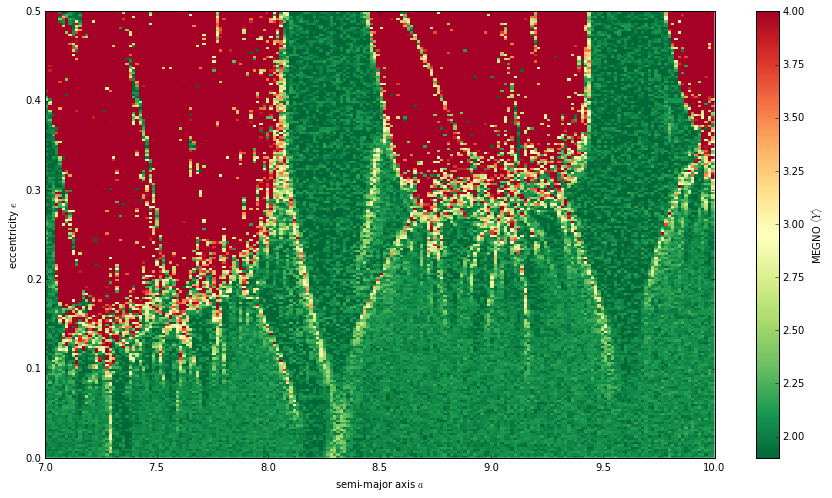

In [5]:
results2d = np.array(results).reshape(Ngrid,Ngrid).T
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,8)); ax = plt.subplot(111)
extent = [parameters[:,0].min(),parameters[:,0].max(),parameters[:,1].min(),parameters[:,1].max()]
ax.set_xlim(extent[0],extent[1])
ax.set_xlabel("semi-major axis $a$")
ax.set_ylim(extent[2],extent[3])
ax.set_ylabel("eccentricity $e$") 
im = ax.imshow(results2d, interpolation="none", vmin=1.9, vmax=4, cmap="RdYlGn_r", origin="lower", aspect='auto', extent=extent)
cb = plt.colorbar(im, ax=ax)
cb.set_label("MEGNO $\\langle Y \\rangle$")